# Log

**26 July** : 
* Added :
    * Methods : tdc(), bb84(), cipher() to Links. bb84() returns a key, cipher() encrypts the key and passes the ciphertext to tdc()
    * Variables : KEY_RESERVOIR to Links.

* Need to add :
    * Methods : extract_key() to Links. To extract a key of required length from the KEY_RESERVOIR
    * Variables : Need to add 'text' to CRs. This will store the data to be sent after encryption
    * Files : Need to add iterated_bb84 -> Qiskit_rebuilt_4 -> Hamming files

**5 August** :
* Added :
    * function k_sp(g) to pre-calculate shortest paths
 
* Modified :
    * Generate_Network_Topology.ipynb : added the function k_sp(g)
    * QKRA.ipynb : getting k_sp from the precalculated dictionary

# Assembled

This is a systematicically assembled file to perform the entire task. Various other files have been called as required to utilize their functionality.

Here, we define the edge data for the graph(NSFNET, Six-Node), followed by creating the graph by invoking a function from another file. The parameters required are defined here, including the X range and k. Then the file 'QKRA' is invoked to perform RWTA.

Following this, the average is calculated from all the runs of QKRA, and the value is plotted.

1. Run BB84 at the start, fill the KEY_RESERVOIR with num_CRs * key_len * avg_hop_count number of *key bits*. This reservoir will be accessible to every link to fetch keys from.
2. Generate the bidirectional Network Topology by providing the edges data. Create a list of k-shortest paths between each node.
3. Set the parameter values(num_CRs, aslc, k, num_iter, *X range*). Initialize the quantities to be studied(SRCR, TUR, NSP).
4. Initiate the QKRA protocol (to be ran  num_iter times)

### QKRA
1. Initialize the links. Allocate the resources.
    * For bidirectional graph, the number of links will double(2 unidirectional link between each available pair of nodes). Ordered Indices   matrix needed.
    * The quantum keys will be associated with each QSC time-slot of each link.
    * Each link will encode/decode the text for CR
2. Generate a set of X CRs. Initialize the attributes.
    * Create a priority queue. Apply FF for each successive shortest path until success/exhaustion.   
    * The text to be sent will be associated with the CR. Call cipher function. Update the quantities of interest.
4. A cipher function will simulate the encryption/decryption of the data for each link involved. Including the usage of TDC.
    * A link (node_1, node_2) with a qkey : Encrypt on node_1, use TDC to share the ciphertext, decrypt on node_2.
    * Q : time for this to be counted?


# 1. Preamble

In [6]:
import numpy as np
import random
import math
import networkx as nx
import matplotlib.pyplot as plt
import os
import time
from tqdm import tqdm, trange

In [7]:
# Define the subdirectory name for storing figures
fig_subdirectory = "Figures"
if not os.path.exists(fig_subdirectory):    # Check if the subdirectory exists
    os.makedirs(fig_subdirectory)
    
# For writing data
data_subdirectory = "Data"
if not os.path.exists(data_subdirectory):
    os.makedirs(data_subdirectory)

# Setting the precision for floating points :
np.set_printoptions(precision=4)

# 2. Loading dependencies

In [9]:
#Running the files in the same directory to gain access to methods

%run ./Generate_Network_Topology.ipynb

%run ./Generating_CRs.ipynb 

%run ./Links.ipynb

# 3. Stock the quantum generated keys

In [11]:
write = False
eve_presence = 'Random'    #'Random'
ch_noise = 1e-4     # 0.000 - 0.300, 0.050 V/s QBER (eve detection)
eve_threshold = 20e-2    # QBER_threshold = eve_threshold - ch_noise ( 0.25(+-0.01) - 0.02 (+-0.001) = 0.23 +- 0.011 )

precision = 5e-5 + 5e-3    
error_threshold = eve_threshold - ch_noise - precision

num_keys = 1000
key_size = 1000
indices = np.arange(num_keys)

time_taken = np.zeros(num_keys, dtype = 'float32')    # avg time taken by a key of a certain length
QBERs = np.zeros(num_keys, dtype = 'float16')


Size and Type :

num_keys           :   Sys size : 28    ,  np size : NA      <class 'int'> 
key_size           :   Sys size : 28    ,  np size : NA      <class 'int'> 
write              :   Sys size : 28    ,  np size : NA      <class 'bool'> 
eve_presence       :   Sys size : 55    ,  np size : NA      <class 'str'> 
ch_noise           :   Sys size : 24    ,  np size : NA      <class 'float'> 
eve_threshold      :   Sys size : 24    ,  np size : NA      <class 'float'> 
Eve_detected       :   Sys size : 1112  ,  np size : 1000      <class 'numpy.ndarray'> 
KEY_RESERVOIR_len  :   Sys size : 2112  ,  np size : 2000      <class 'numpy.ndarray'> 
time_taken         :   Sys size : 4112  ,  np size : 4000      <class 'numpy.ndarray'> 
QBERs              :   Sys size : 2112  ,  np size : 2000      <class 'numpy.ndarray'> 
KEY_RESERVOIR      :   Sys size : 56    ,  np size : NA      <class 'list'> 


Data Examples :
 
num_keys           :  1000
key_size           :  1000
write             

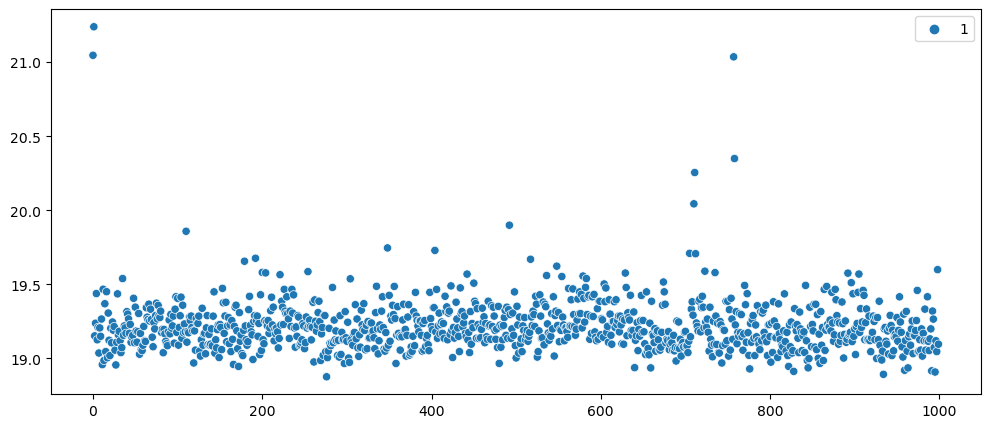


Size and Type :

num_keys           :   Sys size : 28    ,  np size : NA      <class 'int'> 
key_size           :   Sys size : 28    ,  np size : NA      <class 'int'> 
write              :   Sys size : 28    ,  np size : NA      <class 'bool'> 
eve_presence       :   Sys size : 55    ,  np size : NA      <class 'str'> 
ch_noise           :   Sys size : 24    ,  np size : NA      <class 'float'> 
eve_threshold      :   Sys size : 24    ,  np size : NA      <class 'float'> 
Eve_detected       :   Sys size : 1112  ,  np size : 1000      <class 'numpy.ndarray'> 
KEY_RESERVOIR_len  :   Sys size : 2112  ,  np size : 2000      <class 'numpy.ndarray'> 
time_taken         :   Sys size : 4112  ,  np size : 4000      <class 'numpy.ndarray'> 
QBERs              :   Sys size : 2112  ,  np size : 2000      <class 'numpy.ndarray'> 
KEY_RESERVOIR      :   Sys size : 8856  ,  np size : NA      <class 'list'> 


Data Examples :
 
num_keys           :  1000
key_size           :  1000
write             

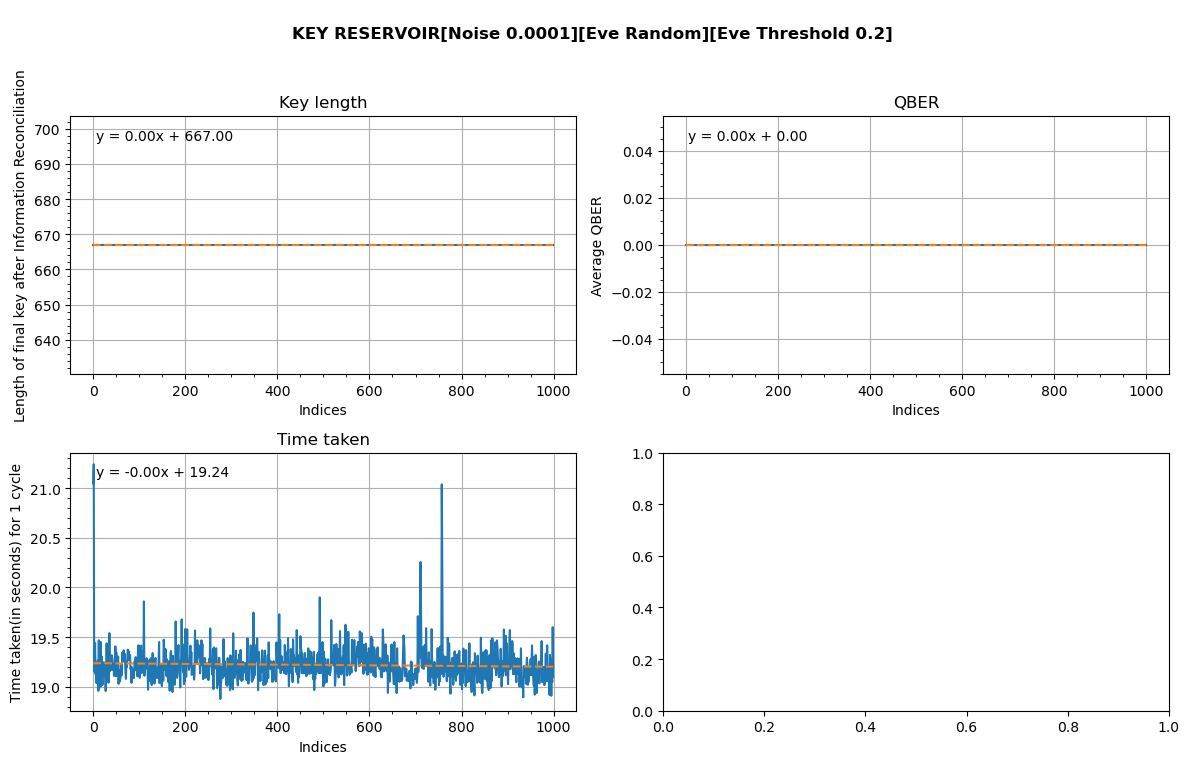


KEY RESERVOIR[Noise 0.0001][Eve Random][Eve Threshold 0.2] 
All_parameters[Noise 0.0001]


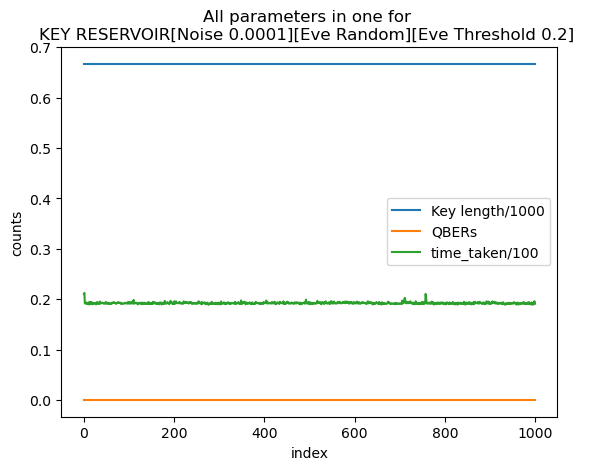

In [12]:
%run ./bb84_reservoir.ipynb    # This will give multiple keys and two variables : KEY_RESERVOIR, KEY_RESERVOIR_len

# 4. Resource Allocation on Optical Communication Network

## 4.1 Given :

In [14]:
# 21 Edges in NSFNET
nsfnet = [ (1, 2, 1100),  #Edge between Node 0 and Node 1
             (2, 3, 1600), #Intermediate Edge between Node 1 and Node 2
             (1, 3, 600), # Edge between Node 0 and Node 2
             (2, 8, 1500), # Edge between Node 1 and Node 7
             (1, 4, 1000),  # Edge between Node 0 and Node 3
             
         (4, 5, 600), # Edge between Node 3 and Node 4
             (5, 7, 800), # Intermediate edge between Node 4 and Node 6
             (7, 8, 700), # Intermediate edge between Node 6 and Node 7
             (10, 11, 900), # Edge Betweeen Node 9 and Node 10
             (4, 9, 1500), # Edge Betweeen Node 3 and Node 8
         
         (9, 12, 800), # Edge Betweeen Node 8 and Node 11
             (8, 10, 700), # Edge Betweeen Node 7 and Node 9
             (10, 12, 500), # Edge Betweeen Node 9 and Node 11
             (9, 14, 800), # Edge Betweeen Node 8 and Node 13
             (10, 14, 500), # Edge Betweeen Node 9 and Node 13
         
         (12, 13, 300), # Edge Betweeen Node 11 and Node 12
             (13, 14, 300), # Edge Betweeen Node 12 and Node 13
             (3, 6, 1000), # Edge Betweeen Node 2 and Node 5
             (6, 5, 1100), # Edge Betweeen Node 5 and Node 4
             (6, 13, 2000), # Edge Betweeen Node 5 and Node 12
         
         (6, 11, 1200), # Edge Betweeen Node 5 and Node 10
        ]


six_nodes = [ 
             (5, 0, 1200), # Edge between Node 5 and Node 0
             (0, 1, 1200), # Edge between Node 0 and Node 1
             (1, 2, 800), # Edge between Node 1 and Node 2
             (2, 3, 900), # Edge between Node 2 and Node 3
             (3, 4, 1000), # Edge between Node 3 and Node 4
             (4, 5, 900), # Edge between Node 4 and Node 5
             (0, 4, 1000), # Intermediate edge between Node 0 and Node 4
             (1, 3, 1000) # Intermediate edge between Node 1 and Node 3
            
    ]

six_nodes
six_nodes = [ (u+1, v+1, w) for (u, v, w) in six_nodes ]    # Increasing the node value by one, so that it starts with 1

In [15]:
print(Links.channel_ts)
print(Links.n_ts)

{1: 8, 2: 10, 3: 12}
{'tdc': 47, 'high': 8, 'medium': 10, 'low': 12}


# Execution

In [37]:
pip install tdqm

Defaulting to user installation because normal site-packages is not writeable
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for tdqm: filename=tdqm-0.0.1-py3-none-any.whl size=1333 sha256=0be4b2babcf00c6801aff462c5ad6077e489ffe6b06d73f1a5fbe8b506163e81
  Stored in directory: c:\users\shivansh\appdata\local\pip\cache\wheels\c8\c7\30\e5935be2cfa6883be72462333edc414d8928f3c78eaabec38a
Successfully built tdqm
Note: you may need to restart the kernel to use updated packages.


In [39]:
from tdqm import tdqm, trange
#%%capture    # To silent the output
# %%timeit    # To Time the entire cell
start_time = time.time()
write = True

edges = nsfnet    # Choosing the network topology : [nsfnet, six_nodes]
topology = 'nsfnet'
dir_edges = edges + [(v, u, w) for (u, v, w) in edges]    # For bidirectional edges

# Creating the network topology(graph)
g, edges = create_bi_topology(dir_edges) 
numNodes = len(g)
k_SP = k_sp(g)    # {(n1, n2) : {(p1) : c1, ..., (pk) : ck}, ..., (n_k_1, n_k) : {p1 : c1, ..., pk : ck} } ; p_i = (l1, l2, ..., l_j)

# Set the ASLC : ['ASSL', 'AWSL', SSL']
aslc = "ASSL"


# Modify: numCR, k, num_iter, j_range, factor
k = 1              # Given parameter
num_iter = 5       # Average over
# numCR = 25         # Number of initial CRs    #numCR = int(input("Input the number of CRs to be generated initially"))
# j_range = 34       # X steps
# factor = 25        # Step multiplication factor. 10 if X>=100    #factor = int(input("Input step size :))
X_i = 400
X_f = 900

steps = int((X_f - X_i)/25 + 1)
# Initializing the arrays to store data of j_range X for num_iter
srcr = np.zeros([num_iter, steps])
tur = np.zeros([num_iter, steps])
nsp = np.zeros([num_iter, steps]).astype(int)
TSUR = np.zeros([num_iter, steps])
SRCR = np.zeros([num_iter, steps])
NSP = np.zeros([num_iter, steps]).astype(int)

CR_desc = np.zeros([num_iter, steps])

# Open the file to write data to
filename = f"QKRA-{aslc}({topology}).txt"
data_path = os.path.join(data_subdirectory, filename)
file = open(data_path, "a")
file.write(f"\n\nQKRA-{aslc}: {topology=}, k = {k}, Averaged over(z) = {num_iter} : \n")


print(f"Running QKRA-{aslc} for # CRs = {X_i} to {X_f} with {steps = }, {k = }, iterations = {num_iter}") 
# Loop to average over the same list of X
for z in trange(num_iter):    
    
    X = X_i    # Initial value of X
    step = 0    
    
    %run ./QKRA.ipynb    # Calling another file to allocate the resources

    print(f"\nIteration {z+1} complete")
    print("#########################################################################################################################################\n")
##
print("Simulation Ended")


end_time = time.time()

ModuleNotFoundError: No module named 'tdqm'

# Calculation

In [ ]:
# Calculating the time taken by simulation

elapsed_time = f"{int((end_time - start_time)/3600)}h {int((end_time - start_time)/60 % 60)}m {(end_time - start_time)%60 : .2f}s"
print(f"Elapsed Time : {elapsed_time}")

In [ ]:
TSUR, NSP, SRCR

In [ ]:
X_range = np.array(range(X_i, X_f+25, 25))

# Initializing arrays to calculate the averages
avg_srcr = np.zeros(steps)
avg_tur = np.zeros(steps)
avg_nsp = np.zeros(steps)
avg_TSUR = np.zeros(steps)
avg_SRCR = np.zeros(steps)
avg_NSP = np.zeros(steps)

for j in range(steps):    # For different values of X
    for i in range(num_iter):    # Summing over num_iter(=100)
        avg_srcr[j] += srcr[i, j] 
        avg_tur[j] += tur[i, j] 
        avg_nsp[j] += nsp[i, j] 
        avg_TSUR[j] += TSUR[i, j]
        avg_SRCR[j] += SRCR[i, j]
        avg_NSP[j] += NSP[i, j]
        
avg_srcr /= num_iter
avg_tur /= num_iter 
avg_nsp /= num_iter
avg_TSUR /= num_iter
avg_SRCR /= num_iter
avg_NSP /= num_iter

for j in range(steps):
    avg_srcr[j] = round(avg_srcr[j], 4)
    avg_tur[j] = round(avg_tur[j], 4) 
    avg_nsp[j] = round(avg_nsp[j], 4) 
    avg_TSUR[j] = round(avg_TSUR[j], 4)
    avg_SRCR[j] = round(avg_SRCR[j], 4)
    avg_NSP[j] = round(avg_NSP[j], 4)

file.write(f"\nX_range = [{', '.join(map(str, X_range))}] \nAverage_SRCR_{aslc} = [{', '.join(map(str, avg_srcr))}] \nAverage_TUR_{aslc} = [{', '.join(map(str, avg_tur))}] \nAverage_NSP_{aslc} = [{', '.join(map(str, avg_nsp))}]\n")
file.close()

# Display Data

In [ ]:
len(X_range), len(avg_srcr), len(avg_tur), len(avg_nsp), len(avg_TSUR), len(avg_SRCR), len(avg_NSP)

In [ ]:
print(f"Average SRCR : {avg_srcr}, \nAverage TUR : {avg_tur}, \nAverage NSP : {avg_nsp}, \nX : {X_range}")

# Plotting

Plot 1 : SRCR and TUR

Plot2 : NSP

In [ ]:
# X
# X_i = 400
# X_f = 900

In [ ]:
# Setting the initial and final X for the plot
# X_i = 25
# X_f = X_range[-1]
# X_f

In [ ]:
# j_X_i = int(X_i/25 - 1)
# j_X_f = int(X_f/25 - 1)
# print(f"Plotting for X = {X_i}(j = {j_X_i}) to X = X_f(j = {j_X_f})")

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 6))    # 1 column for SRCR and TUR, another for NSP

ax1.scatter(X_range, avg_srcr, label='SRCR - scatter')     # [j_X_i:j_X_f+1]
ax1.scatter(X_range, avg_tur, label='TUR - scatter')    # [j_X_i:j_X_f+1]
ax2.scatter(X_range, avg_nsp)    # [j_X_i:j_X_f+1]

ax1.plot(X_range, avg_SRCR, label='SRCR - line')
ax1.plot(X_range, avg_TSUR, label='TUSR - line')
ax2.plot(X_range, avg_NSP)


ax1.set_xlabel('X = Number of CRs')
ax1.set_ylabel('Ratio')
ax1.set_title("SRCR and TUR")
ax1.minorticks_on()
ax1.legend(loc='best')

ax2.set_xlabel('X = Number of CRs')
ax2.set_ylabel('NSP')
ax2.set_title("NSP")
ax2.minorticks_on()
ax2.legend(loc='best')

fig.suptitle(f"Network Evaluation for QKRA-{aslc} : averaged over {num_iter} iterations, k = {k}", y=1.05)  # Place title above subplots
#fig.legend(loc='best')

# Show the plot
plt.tight_layout()  # Adjust spacing between subplots
plt.show()


# Saving the plot
filename = (f"{aslc} - z = {num_iter}, k = {k} for X - {X_i} to {X_f}.jpeg")
print(filename)

# Combine the subdirectory and filename to create the full path
fig_path = os.path.join(fig_subdirectory, filename)
plt.savefig(fig_path, dpi=300, bbox_inches='tight')

#### 